# Train Convolutive 1D network on random data

Set the number of classes you want to classify (nb_class), the number of statistcal modes in your classes (nb_mode), and the dimension of your features (dim).

* On i9-9980HK, with GTX1650 (4Go)
* nb_class = 20
* nb_modes = 5
* dim = 512
* nb_train = 500000
* nb_test = 5000
* batch_size = 2000

### 83s per epoch


In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def create_activation_data(nb,dim,mean,sigma,amp):
    data=[]
    a = []
    df = pd.DataFrame()
    for i in range(dim):
        m = amp * np.exp(-(mean-i)*(mean-i)/(sigma))
        col = np.random.randn(nb) + m
        df[str(i)]=col
    return np.array(df)


In [3]:
def create_one_class(nb,dim, nb_mod = 10):
    amp_max = 5
    mean = np.random.randint(0, dim)
    sigm_max = 50
    sigm_max2 = int(dim/10)+1
    if sigm_max2<sigm_max:
        sigm_max = sigm_max2
    sigma = np.random.randint(1, sigm_max)
    amp = np.random.randint(1, amp_max)
    c0 = create_activation_data(nb,dim,mean,sigma,amp)
    if nb_mod == 1:
        return c0
    
    nb_means = nb_mod*3
    means = []
    for i in range(nb_means):
        means.append((i+1)*dim/(nb_means+1))
    random.shuffle(means)
    c0 = create_activation_data(nb,dim,means[0],sigma,amp)
    for i in range(nb_mod-1):
        sigma = np.random.randint(1, int(dim/4))
        amp = np.random.randint(1, amp_max)
        c0 += create_activation_data(nb,dim,means[i+1],sigma,amp)
    return c0
                              
    
def create_data(nb,dim, nb_class = 5, nb_mod = 10):
    data = []
    nb_all=0
    labels = []
    n=int(nb_class/3)
    if n*3 < nb_class:
        n+=1
    plt.figure(figsize=(nb_class,nb_class))
    for i in range(nb_class):
        c = create_one_class(int(nb/nb_class),dim,nb_mod)
        ax = plt.subplot(n,3,i+1)
        plt.plot(np.mean(c,axis=0))
        ax.set_title('C'+str(i))
        plt.ylim((0, 5))
        data.append(c)
        nb_all+=c.shape[0]
        labels.append(np.zeros(int(nb/nb_class))+i)
    labels = np.array(labels)
    labels = np.array(labels).reshape((nb_all,1))

    data = np.array(data).reshape((nb_all,dim))
    data = pd.DataFrame(data)
    data['labels'] = labels 
    data = shuffle(data)
    labels = data.pop("labels")
    data = np.array(data)
    labels = np.array(labels,dtype=np.int32)
    #labels = tf.keras.utils.to_categorical(labels, num_classes=nb_class)
    return data,labels


(1000, 512)
(500, 512)


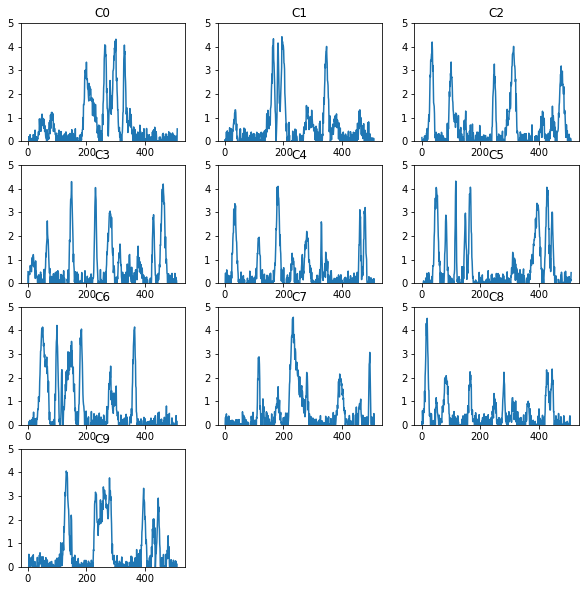

In [4]:

#  Data creation
nb_class = 10
nb_modes = 10
dim = 512
nb_train = 1000
nb_test = 500
train_data,train_labels = create_data(nb_train+nb_test,dim,nb_class,nb_modes)
test_data = train_data[:nb_test,:]
test_labels = train_labels[:nb_test]
train_data = train_data[nb_test:,:]
train_labels = train_labels[nb_test:]



print(train_data.shape)
print(test_data.shape)


In [5]:

m=np.mean(train_data,axis=0).shape
v=np.std(train_data,axis=0).shape
train_data = (train_data-m)/v
test_data = (test_data-m)/v


In [6]:
def create_model(dim):
    inputs = tf.keras.layers.Input(shape=(dim, 1), name='input')
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', name='conv0')(inputs)
    x = tf.keras.layers.Dropout(.1, name='drop0')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, name='MaxPool0')(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', name='conv1')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, name='MaxPool1')(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', name='conv2')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, name='MaxPool2')(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', name='conv3')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, name='MaxPool3')(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', name='conv4')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, name='MaxPool4')(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', name='conv5')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, name='MaxPool5')(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', name='conv6')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, name='MaxPool6')(x)
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dense(16, activation='relu',name='dense')(x)
    outputs = tf.keras.layers.Dense(nb_class, activation='softmax',name='dense_output')(x)    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.002,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(dim)
model.summary()
hist = pd.DataFrame()
nb_epochs = 0


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 1)]          0         
_________________________________________________________________
conv0 (Conv1D)               (None, 512, 128)          768       
_________________________________________________________________
drop0 (Dropout)              (None, 512, 128)          0         
_________________________________________________________________
MaxPool0 (MaxPooling1D)      (None, 256, 128)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 256, 128)          82048     
_________________________________________________________________
MaxPool1 (MaxPooling1D)      (None, 128, 128)          0         
_________________________________________________________________
conv2 (Conv1D)               (None, 128, 128)          82048 

1/1 [==============================] - 0s 67ms/step - loss: 2.3004 - accuracy: 0.1130 - val_loss: 2.3125 - val_accuracy: 0.0740


1/1 [==============================] - 0s 68ms/step - loss: 2.3009 - accuracy: 0.1130 - val_loss: 2.3089 - val_accuracy: 0.0740


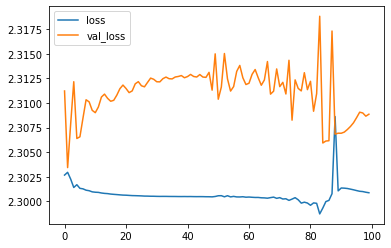

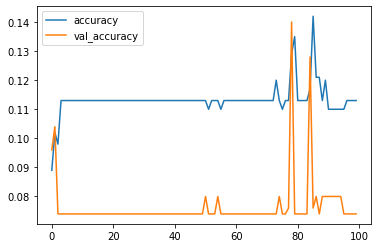

In [7]:
EPOCHS = 100
batch_size = 1000
for i in range(EPOCHS):
    history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels),epochs=1,batch_size=batch_size,shuffle=True)
    hist = hist.append(pd.DataFrame(history.history, index=list(range(nb_epochs,nb_epochs+1))))
    nb_epochs += 1
    if hist["accuracy"][len(hist)-1]>0.95:
        break
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [8]:
def confusion_matrix(model,data,labels,nb_class):
    confusion = np.zeros((nb_class, nb_class))
    nb = len(data)
    predicted = model.predict(data)
    pred = np.argmax(predicted,axis=1)
    print(len(labels.shape))
    if len(labels.shape)==1:
        pred_ref = labels
    else:
        pred_ref = np.argmax(labels,axis=1)
        
    
    n = 0
    for i in range(len(pred)):
        confusion[pred_ref[i]][pred[i]]+=1.
        if pred_ref[i] == pred[i]:
            n+=1

    s = np.sum(confusion,axis=1)
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            confusion[i][j] = confusion[i][j] / s[i]

    accuracy = n/nb
    return confusion,accuracy

def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):
    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap,vmin=0., vmax=1.0)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap,vmin=0., vmax=1.0)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax


1
Accuracy is 7.4%


(<Figure size 1080x1080 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19515f12208>)

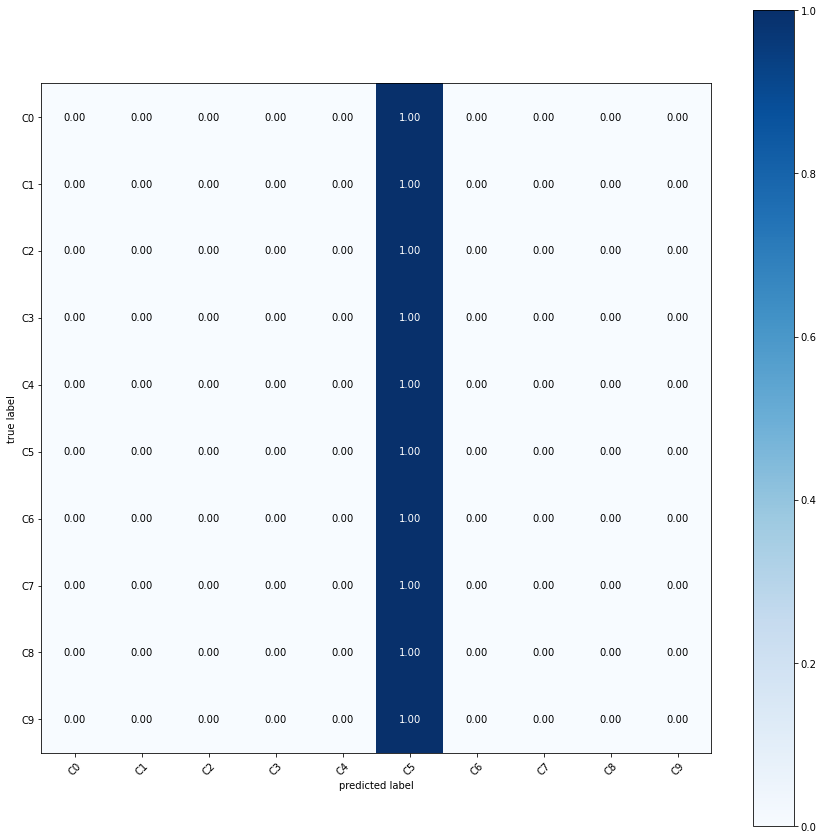

In [9]:
zones = []
for i in range(nb_class):
    zones.append("C"+str(i))
[confusion,accuracy] = confusion_matrix(model,test_data, test_labels,nb_class)
print("Accuracy is "+ str(int(1000.*accuracy)/10.)+"%")
plot_confusion_matrix(conf_mat=confusion, figsize=(len(zones)*1.5,len(zones)*1.5), colorbar=True, show_absolute=False, show_normed=True, class_names=zones) 
